<a href="https://colab.research.google.com/github/PranavDixit2/Dementia/blob/main/Alz_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Step 1: Install Required Libraries
!pip install opencv-python tensorflow gradio kagglehub

# Step 2: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0  # Using EfficientNet
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00


In [3]:
# Step 3: Download Dataset from KaggleHub
print("Downloading dataset...")
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset-v2")
print("Path to dataset files:", path)

100%|██████████| 379M/379M [00:04<00:00, 89.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2/versions/1


In [4]:
dataset_path = "/root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2/versions/1"
for root, dirs, files in os.walk(dataset_path):
    print("Current Directory:", root)
    print("Subdirectories:", dirs)
    print("Files:", files)

# Define paths for training and validation data
train_data_path = os.path.join(dataset_path, "train")
val_data_path = os.path.join(dataset_path, "val")

Current Directory: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2/versions/1
Subdirectories: ['data']
Files: []
Current Directory: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2/versions/1/data
Subdirectories: ['val', 'train']
Files: []
Current Directory: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2/versions/1/data/val
Subdirectories: ['ModerateDemented', 'MildDemented', 'NonDemented', 'VeryMildDemented']
Files: []
Current Directory: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2/versions/1/data/val/ModerateDemented
Subdirectories: []
Files: ['moderateDem6.jpg', '31 (2).jpg', 'moderateDem27.jpg', '27 (2).jpg', '29.jpg', 'moderateDem44.jpg', 'moderateDem49.jpg', 'moderateDem9.jpg', '28 (2).jpg', 'moderateDem38.jpg', 'moderateDem19.jpg', 'moderateDem21.jpg', 'moderateDem31.jpg', 'moderateDem20.jpg', 'moderateDem15.jpg', 'moderateDem45.jpg', 'moderateDem2.jpg', 'moderateDe

In [5]:
# Function to explore the dataset
def explore_dataset(dataset_path):
    class_counts = {}
    total_images = 0

    # Check the structure
    for root, dirs, files in os.walk(dataset_path):
        for folder in dirs:
            folder_path = os.path.join(root, folder)
            num_files = len(os.listdir(folder_path))
            class_counts[folder] = num_files
            total_images += num_files

    print("Dataset Overview:")
    print(f"Total Classes: {len(class_counts)}")
    print(f"Total Images: {total_images}")
    print("Class Distribution:")
    for cls, count in class_counts.items():
        print(f"  {cls}: {count}")

    return class_counts
print("Exploring the dataset...")
class_counts = explore_dataset(dataset_path)

Exploring the dataset...
Dataset Overview:
Total Classes: 7
Total Images: 40394
Class Distribution:
  data: 2
  val: 4
  train: 4
  ModerateDemented: 6464
  MildDemented: 8960
  NonDemented: 9600
  VeryMildDemented: 8960


In [11]:
for root, dirs, files in os.walk(dataset_path):
    print("Current Directory:", root)
    print("Subdirectories:", dirs)
    print("Files:", files)


Current Directory: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2/versions/1
Subdirectories: []
Files: []


In [12]:
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset-v2")
print("Dataset root path:", path)

for root, dirs, files in os.walk(path):
    print("Current Directory:", root)
    print("Subdirectories:", dirs)
    print("Files:", files)


Dataset root path: /kaggle/input/augmented-alzheimer-mri-dataset-v2
Current Directory: /kaggle/input/augmented-alzheimer-mri-dataset-v2
Subdirectories: ['data']
Files: []
Current Directory: /kaggle/input/augmented-alzheimer-mri-dataset-v2/data
Subdirectories: ['val', 'train']
Files: []
Current Directory: /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val
Subdirectories: ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']
Files: []
Current Directory: /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val/ModerateDemented
Subdirectories: []
Files: ['moderateDem40.jpg', 'moderateDem26.jpg', '30.jpg', 'moderateDem48.jpg', 'moderateDem37.jpg', 'moderateDem22.jpg', 'moderateDem36.jpg', 'moderateDem1.jpg', 'moderateDem45.jpg', 'moderateDem31.jpg', 'moderateDem0.jpg', 'moderateDem16.jpg', 'moderateDem44.jpg', '29.jpg', 'moderateDem15.jpg', 'moderateDem12.jpg', '28.jpg', 'moderateDem13.jpg', 'moderateDem18.jpg', 'moderateDem19.jpg', 'moderateDem49.jpg', 'moderateDe

In [13]:
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset-v2/data"
train_data_path = os.path.join(dataset_path, "train")
val_data_path = os.path.join(dataset_path, "val")


Dataset Overview:
Total Classes: 6
Total Images: 40392
Class Distribution:
  val: 4
  train: 4
  ModerateDemented: 6464
  NonDemented: 9600
  VeryMildDemented: 8960
  MildDemented: 8960


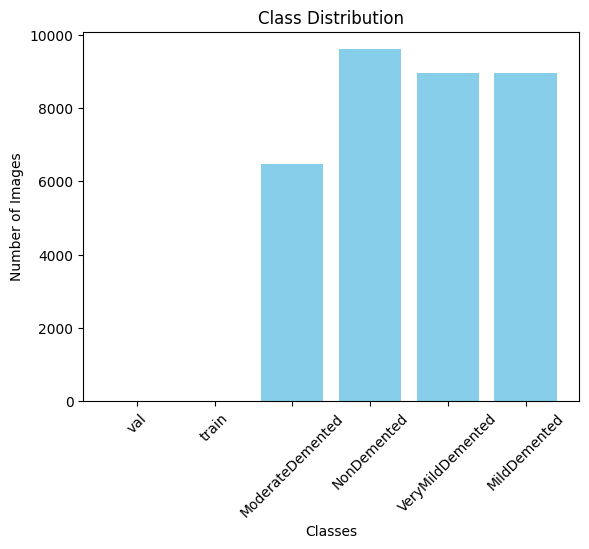

In [14]:
# Explore the dataset
class_distribution = explore_dataset(dataset_path)

# Visualize class distribution
def visualize_distribution(class_distribution):
    classes = list(class_distribution.keys())
    counts = list(class_distribution.values())

    plt.bar(classes, counts, color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title("Class Distribution")
    plt.xticks(rotation=45)
    plt.show()

visualize_distribution(class_distribution)

In [15]:
# Step 4: Define the Target Classes
TARGET_CLASSES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Step 5: Filter Non-Target Folders from train and val directories
def filter_dataset(base_path, target_classes):
    for subfolder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, subfolder)
        if os.path.isdir(folder_path) and subfolder not in target_classes:
            print(f"Removing unrelated folder: {folder_path}")
            os.system(f"rm -rf '{folder_path}'")

filter_dataset(train_data_path, TARGET_CLASSES)
filter_dataset(val_data_path, TARGET_CLASSES)



Removing unrelated folder: /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val
Removing unrelated folder: /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train
Removing unrelated folder: /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val
Removing unrelated folder: /kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train


In [16]:
# Step 6: Setup ImageDataGenerators
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)



In [17]:
# Step 7: Load images using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)



Found 33984 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


Sample Augmented Training Images:


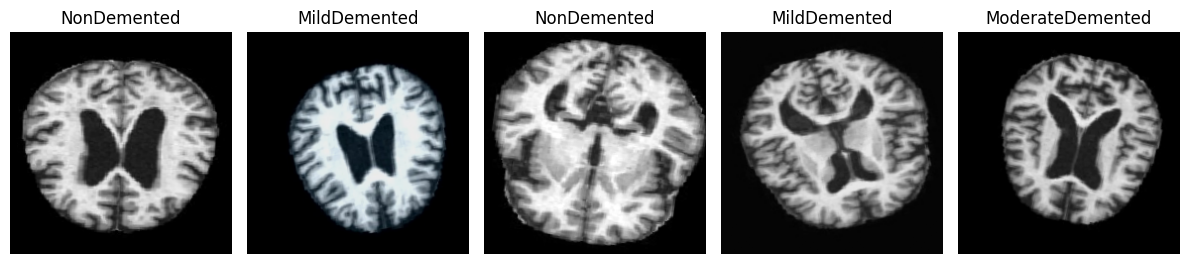

In [18]:
# Step 8: Visualize Some Sample Images from Train Generator
def plot_augmented_images(data_gen, class_indices, num_samples=5):
    label_map = {v: k for k, v in class_indices.items()}
    images, labels = next(data_gen)

    plt.figure(figsize=(12, 5))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(label_map[np.argmax(labels[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Sample Augmented Training Images:")
plot_augmented_images(train_generator, train_generator.class_indices)


In [19]:
# Step 1: Define the Model
def create_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    # Add custom layers on top
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(TARGET_CLASSES), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

model = create_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
# Step 2: Train the Model
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/best_model.h5', save_best_only=True),
    ReduceLROnPlateau(patience=3)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2725 - loss: 1.3816

1062/1062 ━━━━━━━━━━━━━━━━━━━━ 3530s 3s/step - accuracy: 0.2725 - loss: 1.3816 - val_accuracy: 0.5000 - val_loss: 1.2991 - learning_rate: 1.0000e-04
Epoch 2/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 3671s 3s/step - accuracy: 0.2781 - loss: 1.3779 - val_accuracy: 0.5000 - val_loss: 1.3292 - learning_rate: 1.0000e-04
Epoch 3/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 3728s 4s/step - accuracy: 0.2753 - loss: 1.3776 - val_accuracy: 0.5000 - val_loss: 1.3039 - learning_rate: 1.0000e-04
Epoch 4/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 3488s 3s/step - accuracy: 0.2820 - loss: 1.3784 - val_accuracy: 0.5000 - val_loss: 1.3001 - learning_rate: 1.0000e-04
Epoch 5/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 3517s 3s/step - accuracy: 0.2852 - loss: 1.3768 - val_accuracy: 0.5000 - val_loss: 1.3147 - learning_rate: 1.0000e-05


Evaluating the model...
200/200 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00       896
ModerateDemented       0.00      0.00      0.00        64
     NonDemented       0.50      1.00      0.67      3200
VeryMildDemented       0.00      0.00      0.00      2240

        accuracy                           0.50      6400
       macro avg       0.12      0.25      0.17      6400
    weighted avg       0.25      0.50      0.33      6400



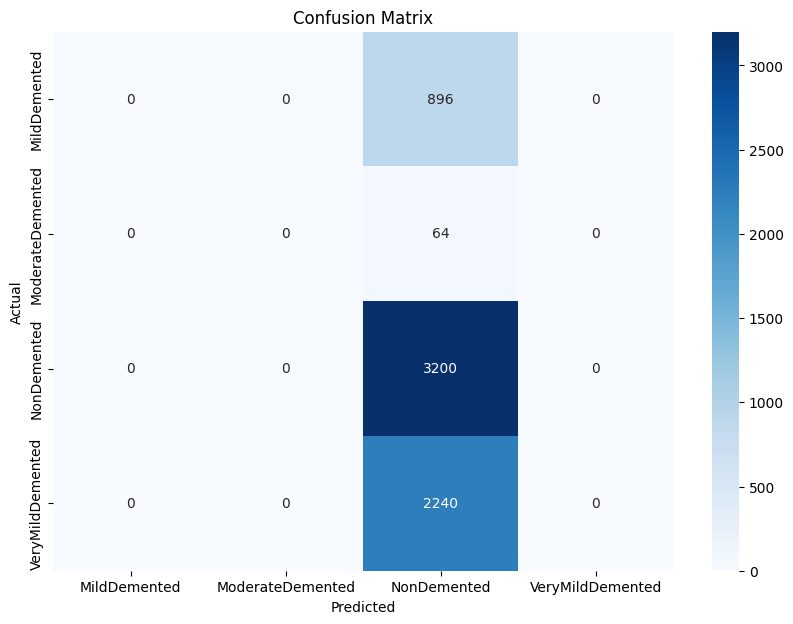

In [22]:
# Step 11: Evaluate the Model
print("Evaluating the model...")
val_predictions = model.predict(val_generator)
val_predictions_classes = np.argmax(val_predictions, axis=1)

# Generate classification report
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())
report = classification_report(true_classes, val_predictions_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(true_classes, val_predictions_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()